# Rossmann Store Sales Prediction 

## Loading, Cleaning, and Transforming

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime

from statsmodels.distributions.empirical_distribution import ECDF

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


In [114]:
train = pd.read_csv('/Users/ultimateflexer/Desktop/Datasets/rossmann-store-sales/train.csv', 
                    index_col = 'Date', parse_dates = True)

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.


In [115]:
train.head(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2015-07-31,6,5,5651,589,1,1,0,1
2015-07-31,7,5,15344,1414,1,1,0,1
2015-07-31,8,5,8492,833,1,1,0,1
2015-07-31,9,5,8565,687,1,1,0,1


In [116]:
store = pd.read_csv('/Users/ultimateflexer/Desktop/Datasets/rossmann-store-sales/store.csv')

In [117]:
store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


## Cleaning

In [118]:
train.info()
print("----------------------------")
store.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortm

### Train Data

- **Store**: The location
- **DayOfWeek**: Starting on Monday as 1, and ending on Sunday as 7.
- **Date**: The date.
- **Sales**: The turnover, or gross revenue, on a given day (target variable).
- **Customers**: The amount of customers on a given day.
- **Open**: Indicator of whether the store was open or closed (0 = closed, 1 = open).
- **Promo**: Indicates if the store was running a promotion that day (0 = no, 1 = yes).
- **StateHoliday**: Indicates if it was a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends (a = public holiday, b = Easter holiday, c = Christmas, 0 = None).
- **SchoolHoliday**: Indicates if the (Store, Date) was affected by the closure of public schools.

In [119]:
train.isnull().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [120]:
# There are no NaN values, but this doesn't mean there aren't missing values in general.
# Let's see how many days the sales are 0

train[train.Sales==0].value_counts().sum()

172871

In [121]:
# Days when the store is closed and sale are 0

closed_no_sales = train[(train.Open == 0) & (train.Sales == 0)]
print(closed_no_sales.shape)
closed_no_sales.head()

(172817, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1
2015-07-31,876,5,0,0,0,1,0,1
2015-07-30,292,4,0,0,0,1,0,1
2015-07-30,876,4,0,0,0,1,0,1
2015-07-29,292,3,0,0,0,1,0,1


In [122]:
print('In', (172817/1017209)*100, '% of cases, the store is closed and the sales are 0.')

In 16.989330609540417 % of cases, the store is closed and the sales are 0.


This will not help us predict future sales, and being as that the data is so extensive in length, it would not hurt to drop this entirely. Let's now see if there are days where the stores were open and there were zero sales.

In [123]:
# Opened stores with zero sales

zero_sales = train[(train.Open == 1) & (train.Sales == 0)]
print(zero_sales.shape)
zero_sales.head()

(54, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1
2015-03-26,674,4,0,0,1,0,0,0
2015-02-05,699,4,0,0,1,1,0,0
2014-10-01,708,3,0,0,1,1,0,0
2014-09-22,357,1,0,0,1,0,0,0


In [124]:
print('In', (54/1017209)*100, '% of cases, the store is open and the sales are 0.')

In 0.005308643553094791 % of cases, the store is open and the sales are 0.


Being as that it is such a small portion of the data, its safe to say that there must be something else going on here, and it is safe to drop this data. 

In [125]:
# Finally, let's extract the year, month, day, and week of year from the date. Being as that the store 
# dataframe has no date information, it would be useful to have this when the date index get's 
# dropped upon merging. There is already a day of week variable, so a week of year will come in handy.

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [126]:
# Finalizing the dataframe. Closed stores and days with 0 sales will be excluded.

train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
train.shape

(844338, 12)

### Store Data

- **Store**: The location (unique id for each store)
- **StoreType**: Differentiates between 4 different store models: a, b, c, d
- **Assortment**: Describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance**: Distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]**: Gives the approximate year and month of the time the nearest competitor was opened
- **Promo2**: A continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]**: Describes the year and calendar week when the store started participating in Promo2
- **PromoInterval**: Describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [127]:
# Check missing values

store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [128]:
store.shape

(1115, 10)

Some features are missing nearly half of their values. Let's further investigate all columns missing values.

In [129]:
# Missing values in CompetitionDistance

store[pd.isnull(store['CompetitionDistance'])]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [130]:
# These rows are entirely missing the CompetitionDistance, being as that there is no way to
# guess the value, I will impute with the mean to keep the data balanced.

store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace = True)

In [131]:
# Missing values in CompetitionOpenSince[Month/Year]

store[pd.isnull(store['CompetitionOpenSinceMonth'])].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
25,26,d,a,2300.0,NaN,NaN,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
31,32,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
39,40,a,a,180.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
40,41,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


In [132]:
# Being as that it cannot be inferred when these stores opened, I will impute these missing
# values with 0 so as to not lose a significant chunk of the data dropping these rows.

store['CompetitionOpenSinceMonth'].fillna(value=0, inplace = True)
store['CompetitionOpenSinceYear'].fillna(value=0, inplace = True)

In [133]:
# Missing values in Promo2Since[Year/Week] and PromoInterval

store[pd.isnull(store['Promo2SinceWeek'])].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
15,16,a,c,3270.0,0.0,0.0,0,NaN,NaN,NaN
22,23,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN


In [134]:
# At first glance, appears that Promo2Since[Year/Week] and PromoInterval are empty when 
# Promo2 is 0. Let's verify this before imputation.

no_promo = store[pd.isnull(store.Promo2SinceWeek)]
no_promo[no_promo.Promo2 != 0].shape

(0, 10)

In [135]:
# As suspected, there are so many null values in the columns related to Promo2 when there is no
# Promo2. These will be imputed with 0.

store['Promo2SinceWeek'].fillna(0, inplace = True)
store['Promo2SinceYear'].fillna(0, inplace = True)
store['PromoInterval'].fillna(0, inplace = True)

In [136]:
# Final check for missing values

store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

Much better! Now that both dataframes are clean, let's see if we can merge them.

In [137]:
# Join train and store on the 'Store' column, using an inner merge

train_store = pd.merge(train, store, on='Store', how='inner', sort=True)
print(train_store.shape)
train_store.head(10)

(844338, 21)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
5,1,6,4364,500,1,0,0,0,2015,7,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,5,3706,459,1,0,0,0,2015,7,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,4,3769,503,1,0,0,0,2015,7,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,3,3464,463,1,0,0,0,2015,7,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,2,3558,469,1,0,0,0,2015,7,...,30,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## Exploratory Data Analysis

In [138]:
# Create a new column 'SalesPerCustomer'

train_store['SalePerCustomer'] = train_store['Sales']/train_store['Customers']
train_store['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average, the gross revenue per customer per day is about \\$9.50. The upper limit is approximately \\$65, and the lower limit is obviously \\$2.75 for people who just browse.

Let's plot the ECDF to further get an understanding of how the sales are distributed. The ECDF stands for the Empirical Cumulative Distribution function, and is the distribution function associated with the empirical measure of a sample. Its value at any specified value of the measured variable is the fraction of observations of the measured variable that are less than or equal to the specified value.

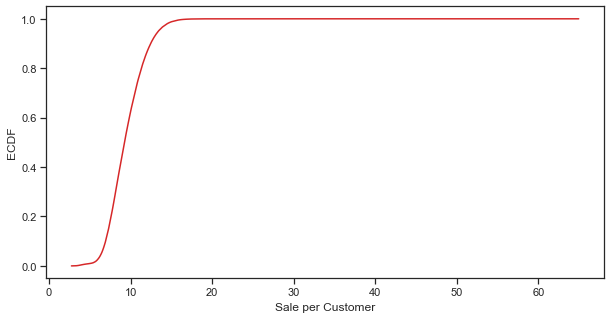

In [139]:
sns.set(style = "ticks") # format into seaborn 
c = '#d62728' # color for the line

plt.figure(figsize = (10, 5))
cdf = ECDF(train_store['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sale per Customer')
plt.ylabel('ECDF')
plt.show()

Although the maximum sale per customer is \\$65, it is very rare for a customer to spend that much, seeing as that lmost 100\% of the customers spend less than about \\$15.

### Store Type Analysis

Being as that there are about 3,000 stores, it wouldn't make sense to aggregate on each store for analysis. Instead, lets observe the StoreType column and see how many unique values it has.

In [140]:
train_store['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [141]:
# Only 4 values, so lets aggregate by the StoreType and see how the sales look per type

sales_by_type_sumstat = train_store.groupby('StoreType')['Sales'].describe()
sales_by_type_sumstat['sum'] = train_store.groupby('StoreType')['Sales'].sum()
sales_by_type_sumstat

,count,mean,std,min,25%,50%,75%,max,sum
StoreType,,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0,3165334859
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0,159231395
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0,783221426
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0,1765392943


In [142]:
sales_by_type_sumstat = sales_by_type_sumstat.reset_index()

Text(0, 0.5, 'Aggregated Average Sales')

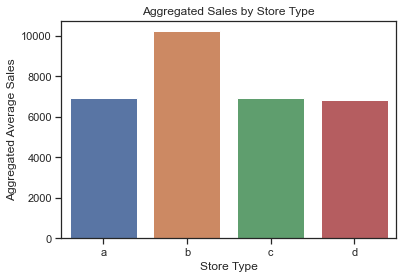

In [143]:
sns.barplot(data=sales_by_type_sumstat, x='StoreType', y='mean')
plt.title('Aggregated Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Aggregated Average Sales')

Text(0, 0.5, 'Aggregated Total Sales')

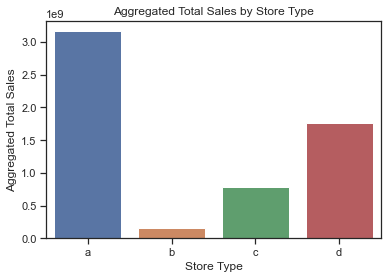

In [144]:
sns.barplot(data=sales_by_type_sumstat, x='StoreType', y='sum')
plt.title('Aggregated Total Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Aggregated Total Sales')

Store type b has the highest average sales, but the least in total. This could mean that it still has the highest frequency of customers and sales comparitively, there is just not as many stores of type b. Let's check out the sales per customer aggregated by StoreType.

In [145]:
salesPerCust_by_type_sumstat = train_store.groupby('StoreType')['SalePerCustomer'].describe()
salesPerCust_by_type_sumstat

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,8.846296,1.690913,3.635389,7.611945,8.631363,9.899438,29.877551
b,15560.0,5.133427,1.253988,2.749075,4.039561,4.987022,6.108760,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


In [146]:
salesPerCust_by_type_sumstat = salesPerCust_by_type_sumstat.reset_index()

Text(0, 0.5, 'Aggregated Sales per Customer')

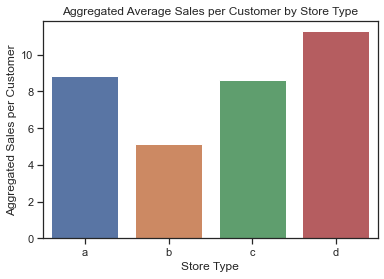

In [147]:
sns.barplot(data=salesPerCust_by_type_sumstat, x='StoreType', y='mean')
plt.title('Aggregated Average Sales per Customer by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Aggregated Sales per Customer')

Store type d actually has the highest average sale per customer. This is counterintuitive because it ranked lowest on average sales in general. Let's look at the same data but aggregated on the total customers, to see which store type has the most foot traffic.

In [148]:
cust_sales_by_store_type_total = train_store.groupby('StoreType')['Customers'].sum()
cust_sales_by_store_type_total

StoreType
a    363541431
b     31465616
c     92129705
d    156904995
Name: Customers, dtype: int64

In [149]:
cust_sales_by_store_type_total = cust_sales_by_store_type_total.reset_index()

Text(0, 0.5, 'Total Custoemrs')

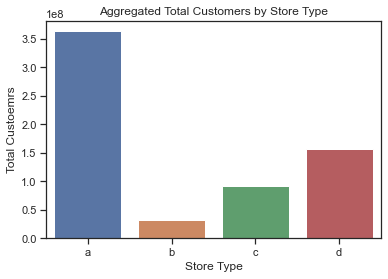

In [150]:
sns.barplot(data=cust_sales_by_store_type_total, x='StoreType', y='Customers')
plt.title('Aggregated Total Customers by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Custoemrs')

Initial conclusions from these tables and charts tables:
- Type **a**: First in total number of customers and sales, third in average sales value, second in average sales per customer.
- Type **b**: Last in total customers and sales, first in average sales value, last in average sales per customer.
- Type **c**: Third in total sales and customers, second in average sales value, third in average sales per customer.
- Type **d**: Second in total number of customers and sales, last in average sales value, first in average sales per customer.

These are quite general summary statistics, and although useful, they don't paint the whole picture. We still have promos and holidays to worry about. Let's see how the sales trend when promos are considered.

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


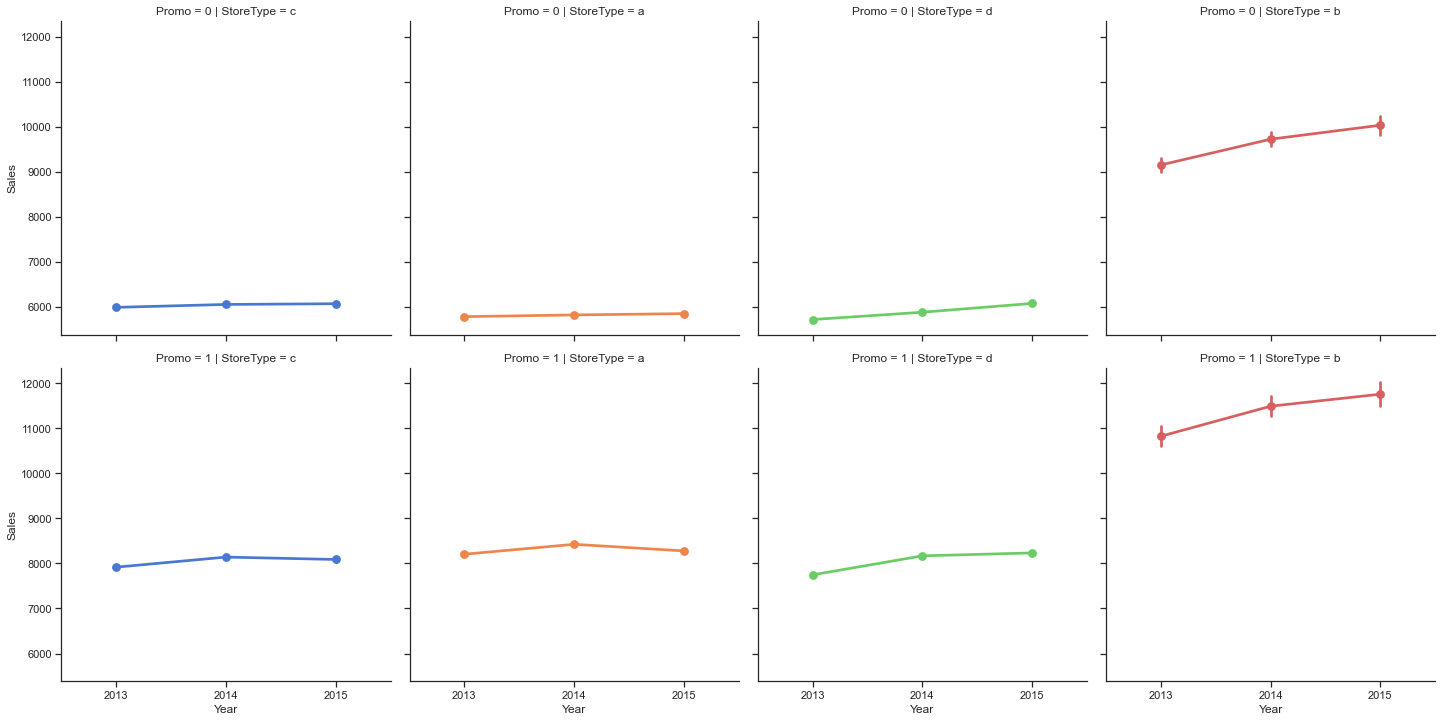

In [151]:
sns.factorplot(data = train_store, x = 'Year', y = 'Sales', 
               col = 'StoreType', # per store type in cols
               palette = 'muted',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


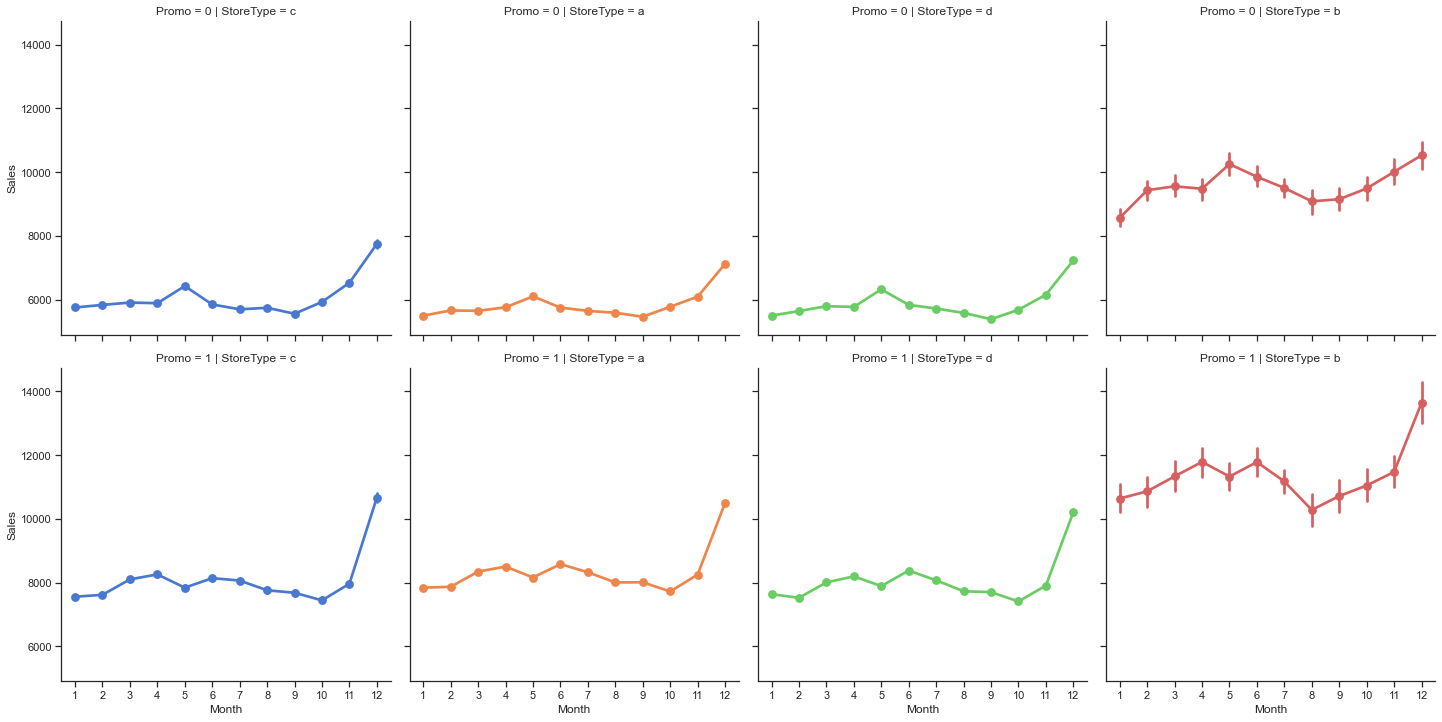

In [152]:
sns.factorplot(data = train_store, x = 'Month', y = 'Sales', 
               col = 'StoreType', # per store type in cols
               palette = 'muted',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


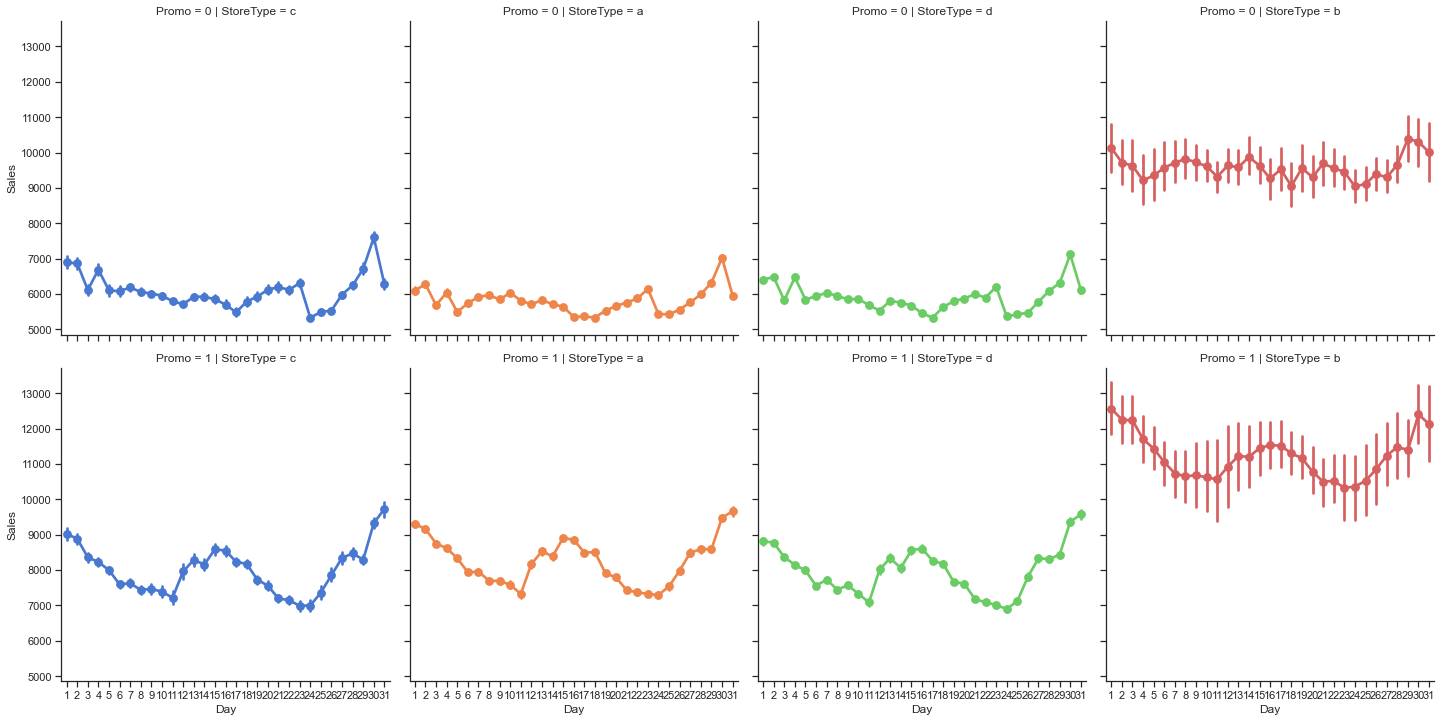

In [153]:
sns.factorplot(data = train_store, x = 'Day', y = 'Sales', 
               col = 'StoreType', # per store type in cols
               palette = 'muted',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

As expected, sales are higher when there is a promo being ran. Let's see how sales vary by day of the week, (Monday = 1, ..., Sunday = 7)

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


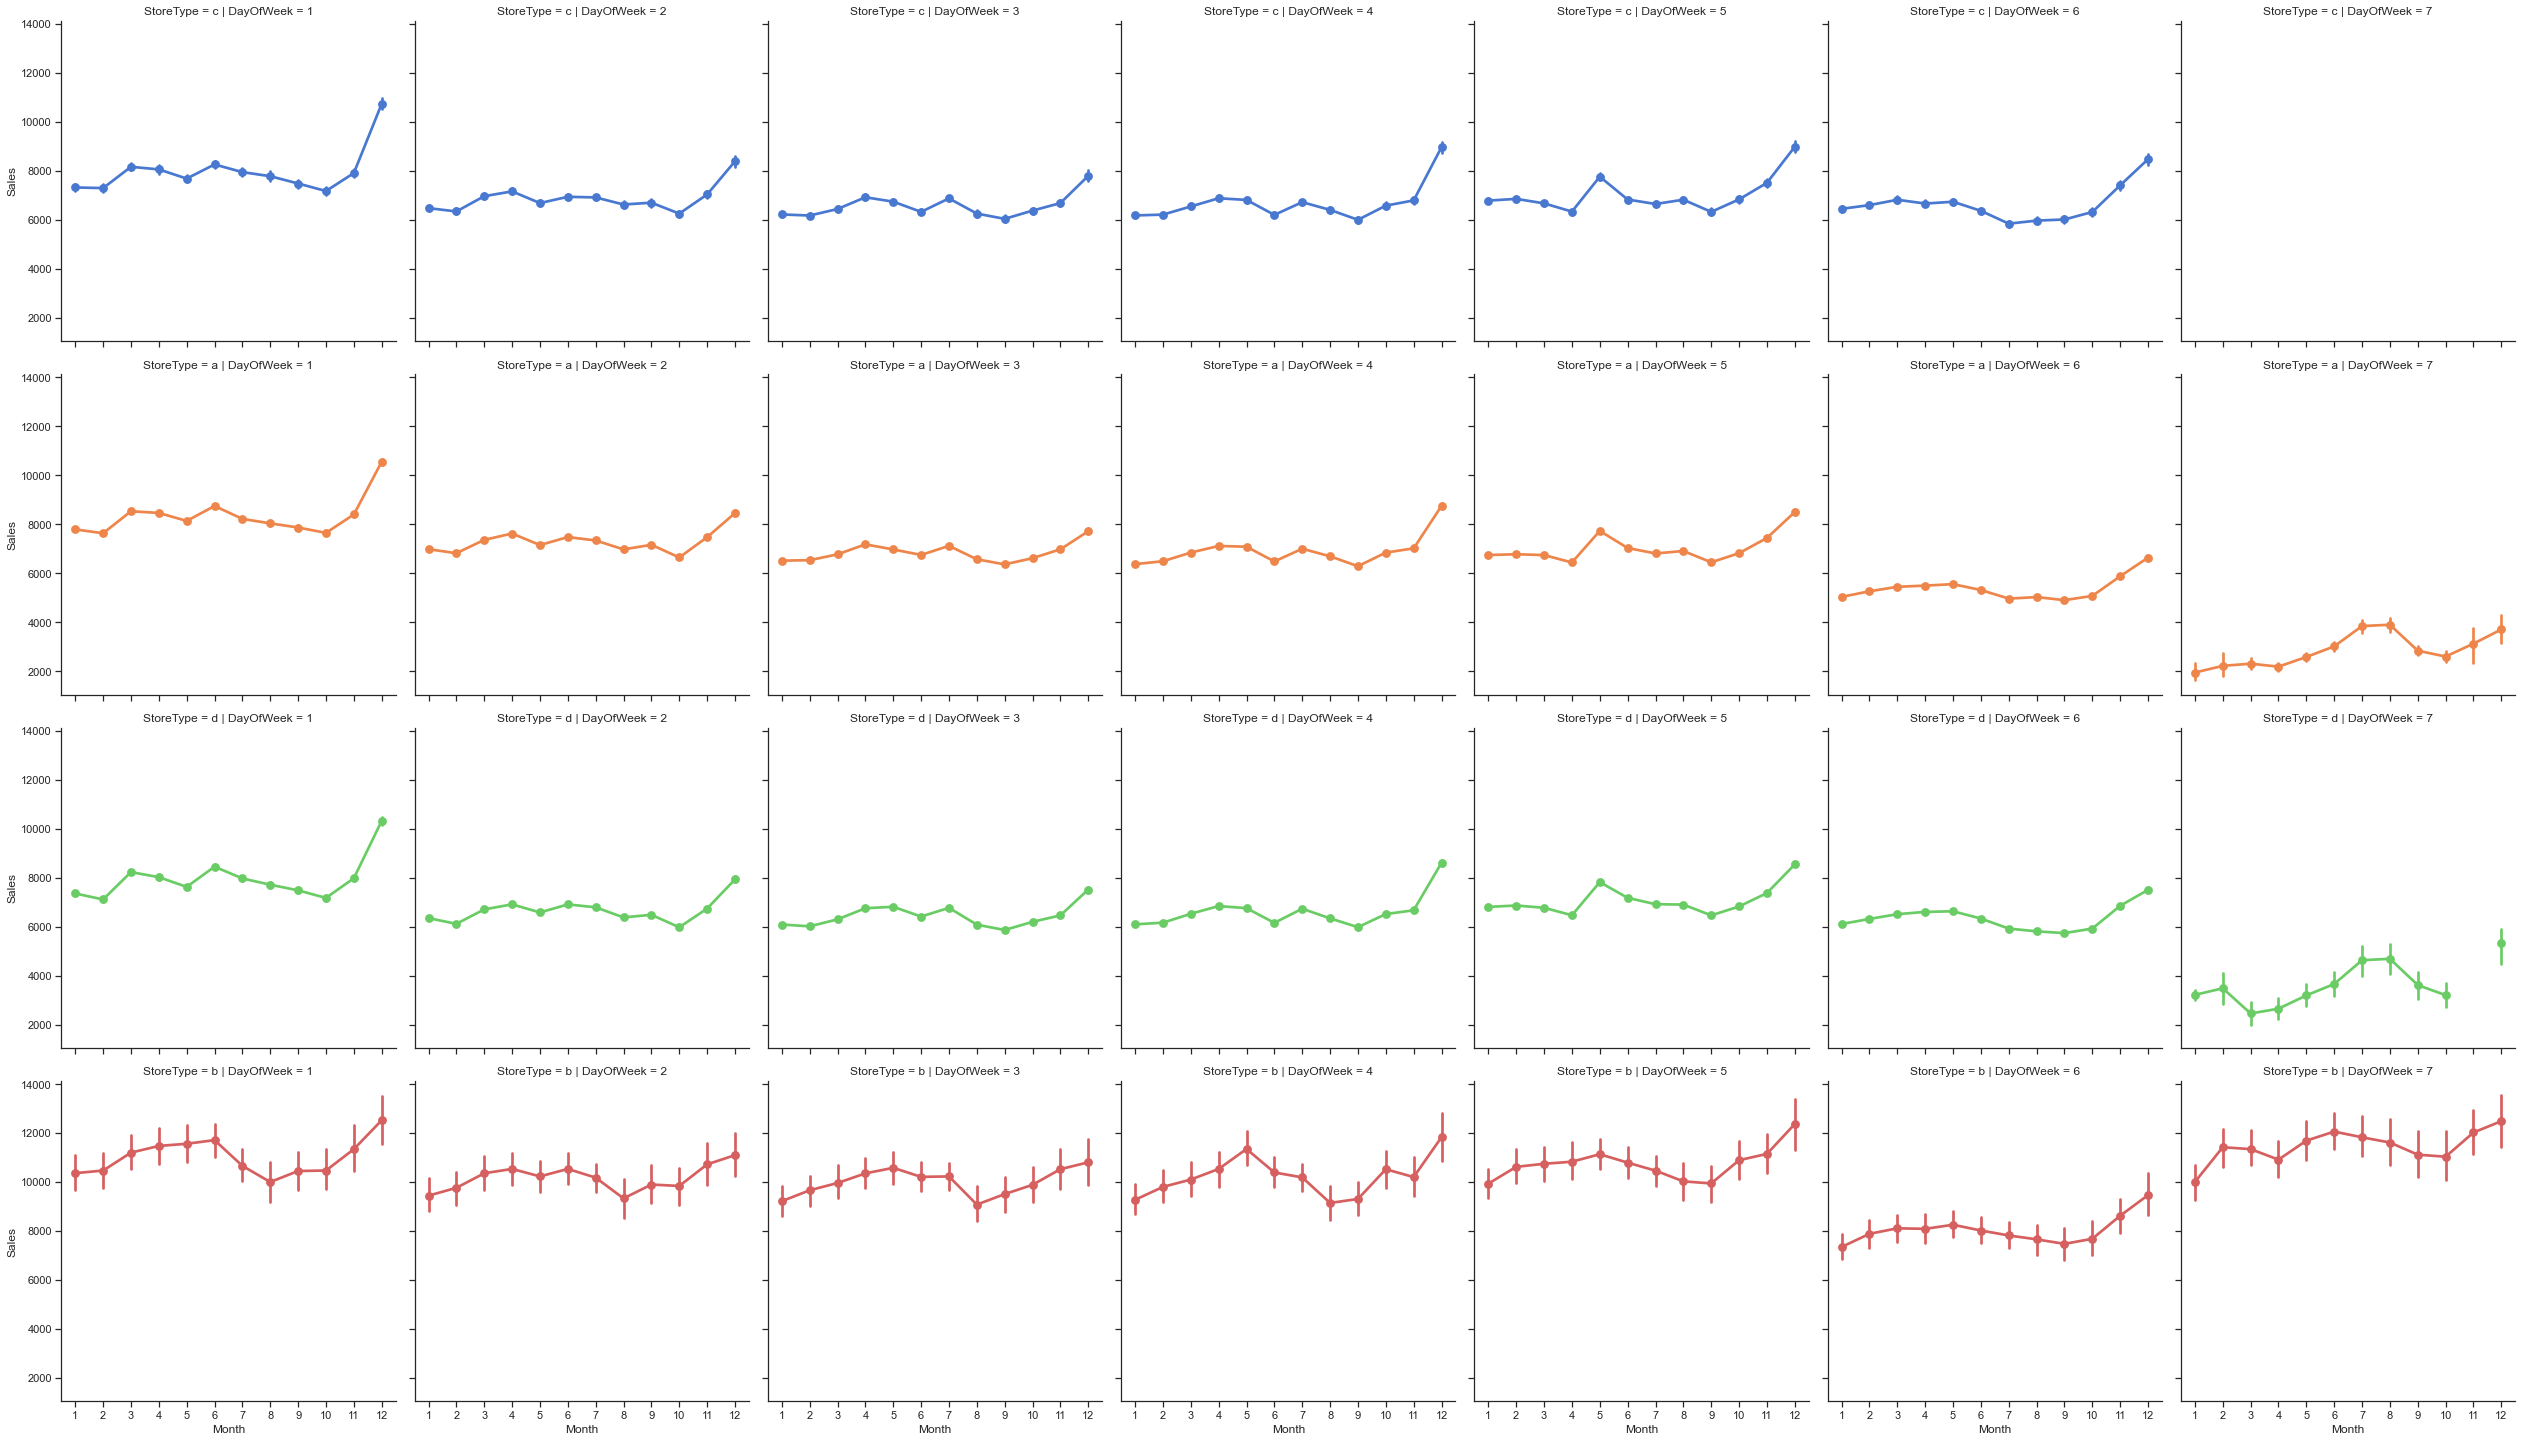

In [154]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'muted',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 

Sales seem pretty consistent from day to day, with some obvious trends upwards towards the end of the year and minor dips around August/September in most cases. Apparently store type c is closed on Sundays, and some stores of type d are closed on Sundays in October, November, and December. Let's check out what percentage of stores are closed on Sundays. 

In [155]:
no_sundays = train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()
print(no_sundays.size / train_store['Store'].unique().size * 100, '% of stores are closed on Sundays' )

2.9596412556053813 % of stores are closed on Sundays


In [156]:
# Average CompetitionDistance time per store type
distance = train_store.groupby('StoreType')['CompetitionDistance'].mean()
distance = distance.reset_index()
distance

,StoreType,CompetitionDistance
0,a,5228.185905
1,b,1072.572622
2,c,3514.147192
3,d,6976.274815


Text(0, 0.5, 'Average Competition Distance in Meters')

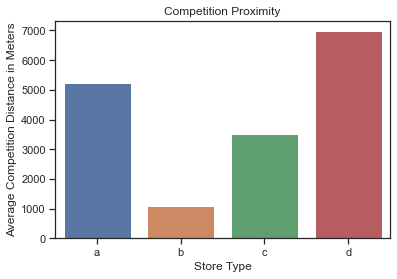

In [241]:
sns.barplot(data=distance, x='StoreType', y='CompetitionDistance')
plt.title('Competition Proximity')
plt.xlabel('Store Type')
plt.ylabel('Average Competition Distance in Meters')

Although store type **a** has the most sales and customers, it ranks second in distance to competition. Store type **b** has the lowest distance to competition. Store type **d** has the highest. 

### Feature Correlations

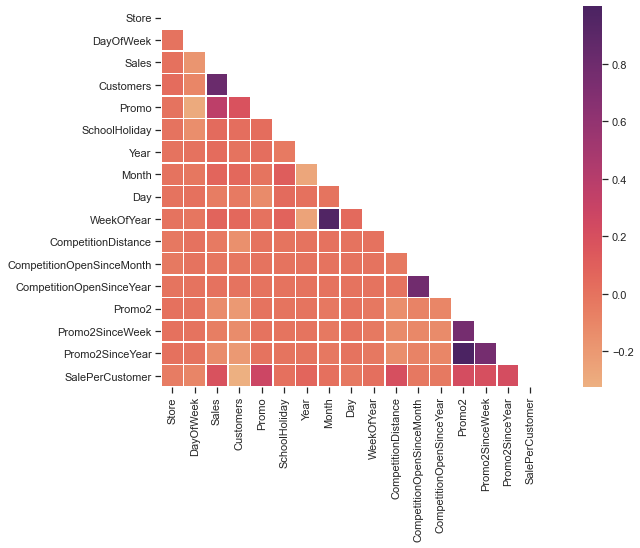

In [158]:
# Compute the correlation matrix
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_all, dtype=bool))


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 7))

sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax=ax, cmap = "flare")      
plt.show()

In [159]:
# Let's observe the columns with interesting shades of correlation

columns_corr = ['Sales', 'Customers', 'Promo', 'Promo2', 'Promo2SinceWeek', 'SalePerCustomer']
subset = train_store[columns_corr]
print(subset.corr())

                    Sales  Customers     Promo    Promo2  Promo2SinceWeek  \
Sales            1.000000   0.823552  0.368199 -0.127556        -0.058493   
Customers        0.823552   1.000000  0.182859 -0.202207        -0.130864   
Promo            0.368199   0.182859  1.000000 -0.000316        -0.000795   
Promo2          -0.127556  -0.202207 -0.000316  1.000000         0.759536   
Promo2SinceWeek -0.058493  -0.130864 -0.000795  0.759536         1.000000   
SalePerCustomer  0.186563  -0.323926  0.280027  0.215883         0.198835   

                 SalePerCustomer  
Sales                   0.186563  
Customers              -0.323926  
Promo                   0.280027  
Promo2                  0.215883  
Promo2SinceWeek         0.198835  
SalePerCustomer         1.000000  


In order of correlation strength with sales, these can be ranked Customers, Promo, and SalePerCustomer. Customers has a decently strong correlation with PromoOpen, meaning that its likely that running a promo draws more customers. Interestingly, Promo2 and related variables seem to have a negative correlation with sales. Let's further investigate.

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.


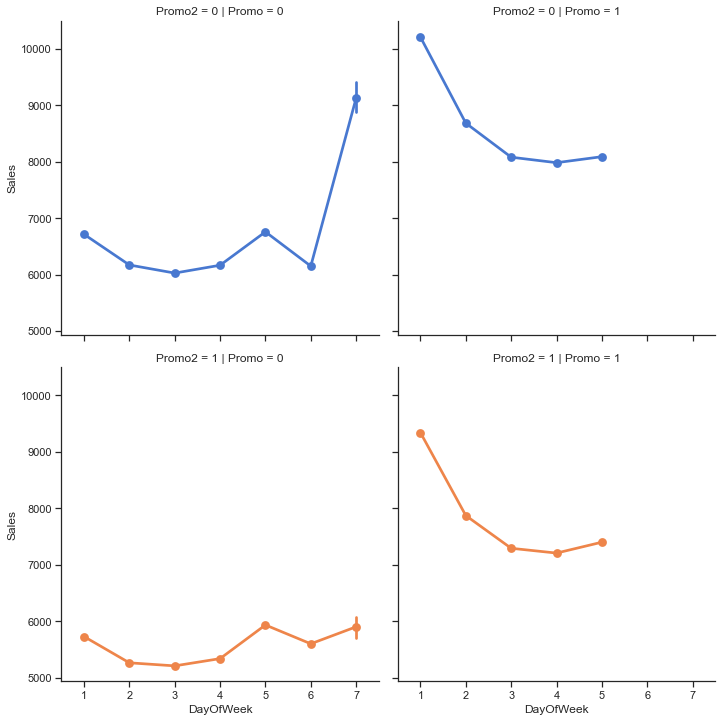

In [160]:
# Plot sales separated by promo and promo2 for the smallest time measurement, DayOfWeek

sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               palette = 'muted',
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2')

- When there are no promotions at all (top left plot), the sales rise slowly through the week, dip slightly on Saturday, and shoot up on Sunday.
- When both promos are being ran (bottom right), sales are the highest on Mondays, but this trend does not differ from when promo is running alone without promo2.
- Sales for only promo2 are fairly low, with no significant changes from day to day.

## Conclusions
- Store type **a** has the most sales and customers in total.
- Store type **b** has the lowest sales per customer on average, but highest average sales quantity across stores. This would mean that they most likely sell a lot of cheap things. 
- Store type **d** has the highest sales per customer, but is still beat by **a** by about twice as much in terms of total sales and customers. This eludes to them selling fewer, more expensive things.
- Customers seem to spend the most money on Sunday when there are no promotions, and the most on Mondays when there are promotions.
- Promo2 does not seem to help sales in any clear way, while promo definitely does. 

## Feaure Engineering and Preprocessing

I have already created some new features in this notebook for exploratory analysis, so the main goal of the feature engineering here will be to deal with categorical features.

In [161]:
# To get the final working dataframe to be as simple as possible, let's rename as df and check
# the current shape
df = train_store
print(df.shape)
df.head()

(844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalePerCustomer
0,1,5,5263,555,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,1,4,5020,546,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.194139
2,1,3,4782,523,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.143403
3,1,2,5011,560,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.948214
4,1,1,6102,612,1,1,0,1,2015,7,...,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.970588


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Sales                      844338 non-null  int64  
 3   Customers                  844338 non-null  int64  
 4   Open                       844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   Year                       844338 non-null  int64  
 9   Month                      844338 non-null  int64  
 10  Day                        844338 non-null  int64  
 11  WeekOfYear                 844338 non-null  int64  
 12  StoreType                  844338 non-null  object 
 13  Assortment                 84

In [163]:
# Drop the Store column, as it will no longer be necessary for modeling

df.drop('Store', axis=1, inplace=True)

In [164]:
# Change the DayOfWeek values to their respected day, then one-hot encoding these 
# values. I will be using the actual day names to make things clearer

df['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 6, 7])

In [165]:
df['DayOfWeek'].replace({1: 'Mon', 
                         2: 'Tues', 
                         3: 'Wed', 
                         4: 'Thur', 
                         5: 'Fri', 
                         6: 'Sat', 
                         7: 'Sun'}, inplace=True)
df['DayOfWeek'].unique()

array(['Fri', 'Thur', 'Wed', 'Tues', 'Mon', 'Sat', 'Sun'], dtype=object)

In [166]:
DayOfWeek_cols = pd.get_dummies(df.DayOfWeek, prefix='Day: ')
df.drop(columns='DayOfWeek', inplace=True)
df = pd.concat([df, DayOfWeek_cols], axis=1, join='inner')

In [167]:
# State holiday has some similar issues as the DayOfWeek column, that being unclear characters
# for each holiday, let's investigate

df['StateHoliday'].unique()

array(['0', 0, 'a', 'b', 'c'], dtype=object)

In [168]:
df['StateHoliday'].replace({'0':None,
                            0:None,
                           'a':'public',
                           'b':'easter',
                           'c':'christmas'}, inplace=True)
df['StateHoliday'].unique()

array([None, 'public', 'easter', 'christmas'], dtype=object)

In [169]:
StateHoliday_cols = pd.get_dummies(df.StateHoliday, prefix='State Holiday: ')
df.drop(columns='StateHoliday', inplace=True)
df = pd.concat([df, StateHoliday_cols], axis=1, join='inner')

In [170]:
df.head()

,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,...,Day: _Fri,Day: _Mon,Day: _Sat,Day: _Sun,Day: _Thur,Day: _Tues,Day: _Wed,State Holiday: _christmas,State Holiday: _easter,State Holiday: _public
0,5263,555,1,1,1,2015,7,31,31,c,...,1,0,0,0,0,0,0,0,0,0
1,5020,546,1,1,1,2015,7,30,31,c,...,0,0,0,0,1,0,0,0,0,0
2,4782,523,1,1,1,2015,7,29,31,c,...,0,0,0,0,0,0,1,0,0,0
3,5011,560,1,1,1,2015,7,28,31,c,...,0,0,0,0,0,1,0,0,0,0
4,6102,612,1,1,1,2015,7,27,31,c,...,0,1,0,0,0,0,0,0,0,0


In [171]:
df.shape

(844338, 29)

In [172]:
# One-hot encode store types

StoreType_cols = pd.get_dummies(df.StoreType, prefix='Store Type: ')
df.drop(columns='StoreType', inplace=True)
df = pd.concat([df, StoreType_cols], axis=1, join='inner')

In [173]:
Assortment_cols = pd.get_dummies(df.Assortment, prefix='Assortment: ')
df.drop(columns='Assortment', inplace=True)
df = pd.concat([df, Assortment_cols], axis=1, join='inner')

In [174]:
PromoInterval_cols = pd.get_dummies(df.PromoInterval, prefix='PromoInterval: ')
df.drop(columns='PromoInterval', inplace=True)
df = pd.concat([df, PromoInterval_cols], axis=1, join='inner')

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 37 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Sales                             844338 non-null  int64  
 1   Customers                         844338 non-null  int64  
 2   Open                              844338 non-null  int64  
 3   Promo                             844338 non-null  int64  
 4   SchoolHoliday                     844338 non-null  int64  
 5   Year                              844338 non-null  int64  
 6   Month                             844338 non-null  int64  
 7   Day                               844338 non-null  int64  
 8   WeekOfYear                        844338 non-null  int64  
 9   CompetitionDistance               844338 non-null  float64
 10  CompetitionOpenSinceMonth         844338 non-null  float64
 11  CompetitionOpenSinceYear          844338 non-null  f

In [176]:
# Make sure there are no records where stores are closed or sales are 0

print(df[df['Open']==0].shape)
print(df[df['Sales']==0].shape)

(0, 37)
(0, 37)


In [177]:
# Looks good, one last check for null values

df.isnull().sum()

Sales                               0
Customers                           0
Open                                0
Promo                               0
SchoolHoliday                       0
Year                                0
Month                               0
Day                                 0
WeekOfYear                          0
CompetitionDistance                 0
CompetitionOpenSinceMonth           0
CompetitionOpenSinceYear            0
Promo2                              0
Promo2SinceWeek                     0
Promo2SinceYear                     0
SalePerCustomer                     0
Day: _Fri                           0
Day: _Mon                           0
Day: _Sat                           0
Day: _Sun                           0
Day: _Thur                          0
Day: _Tues                          0
Day: _Wed                           0
State Holiday: _christmas           0
State Holiday: _easter              0
State Holiday: _public              0
Store Type: 

### Preprocessing

In [178]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

Train/Test Split

In [179]:
X = df.drop(['Sales'], axis=1)
y = df['Sales']

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

Removing multicolinearity with variance inflation factor (VIF)

In [181]:
def iterate_vif(df, vif_threshold=5.7, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    if vif['VIFactor'].max() > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max()
    else:
      print('Complete')
      return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(X_train)

Iteration # 1


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Promo2 with VIF of inf
Iteration # 2


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Day: _Fri with VIF of inf
Iteration # 3


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Store Type: _a with VIF of inf
Iteration # 4


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing Assortment: _a with VIF of inf
Iteration # 5


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Removing PromoInterval: _0 with VIF of inf
Iteration # 6
Removing Open with VIF of 7345723.610900
Iteration # 7
Removing Promo2SinceYear with VIF of 1627286.052725
Iteration # 8
Removing Month with VIF of 57.156186
Iteration # 9
Removing Year with VIF of 52.026515
Iteration # 10
Removing SalePerCustomer with VIF of 20.022948
Iteration # 11
Removing CompetitionOpenSinceYear with VIF of 8.156447
Iteration # 12
Complete


In [182]:
final_vif.sort_values(by='VIFactor', ascending=False)

,VIFactor,features
0,5.227738,Customers
7,3.775175,Promo2SinceWeek
3,3.740556,Day
4,3.467383,WeekOfYear
23,3.095265,"PromoInterval: _Jan,Apr,Jul,Oct"
17,2.474988,Store Type: _b
1,2.224932,Promo
6,2.189495,CompetitionOpenSinceMonth
20,2.116724,Assortment: _b
21,2.069636,Assortment: _c


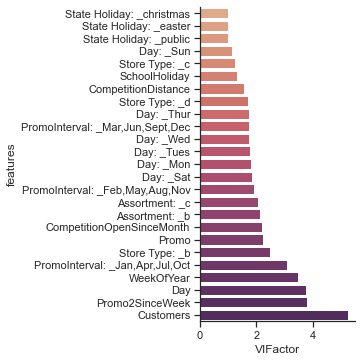

In [183]:
sns.catplot(x='VIFactor', y='features', data=final_vif, kind='bar', orient='h',
           palette ="flare")

Build finally train/test split from the above features.

In [184]:
final_features = final_df.columns.tolist()
final_features

['Customers',
 'Promo',
 'SchoolHoliday',
 'Day',
 'WeekOfYear',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'Promo2SinceWeek',
 'Day: _Mon',
 'Day: _Sat',
 'Day: _Sun',
 'Day: _Thur',
 'Day: _Tues',
 'Day: _Wed',
 'State Holiday: _christmas',
 'State Holiday: _easter',
 'State Holiday: _public',
 'Store Type: _b',
 'Store Type: _c',
 'Store Type: _d',
 'Assortment: _b',
 'Assortment: _c',
 'PromoInterval: _Feb,May,Aug,Nov',
 'PromoInterval: _Jan,Apr,Jul,Oct',
 'PromoInterval: _Mar,Jun,Sept,Dec']

In [185]:
X = df[final_features]
y = df['Sales']

In [186]:
print(X.shape, y.shape)

(844338, 25) (844338,)


In [187]:
# Final split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Modeling

I will be fitting 4 models here, and testing their predictive power to see which model performs the best. These models will be linear regression, lasso regression, random forrest regression, and xg boost regression. The metric of choice for comparison is the RMSPE or **R**oot **M**ean **S**quared **P**ercentage **E**rror.

In [188]:
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from math import sqrt
from xgboost.sklearn import XGBRegressor

In [189]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

In [190]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

#Scores
lr_rmspe =  rmspe(y_test, y_pred)

In [191]:
print('Linear Regression RMSPE: ', lr_rmspe)

Linear Regression RMSPE:  0.19404070351221114


In [192]:
#Lasso Regression Model
lassr = LassoLars()
lassr.fit(X_train, y_train)
y_pred = lassr.predict(X_test)

#Scores
lassr_rmspe = rmspe(y_test, y_pred)

In [193]:
print('Lasso Regression RMSPE: ', lassr_rmspe)

Lasso Regression RMSPE:  0.36377206141566304


In [194]:
#Random Forest Regressor Model
randfr = RandomForestRegressor(n_estimators=10, max_depth=10)
randfr.fit(X_train, y_train)
y_pred = randfr.predict(X_test)

#Scores
randfr_rmspe = rmspe(y_test, y_pred)

In [195]:
print('Random Forest Regression RMSPE: ', randfr_rmspe)

Random Forest Regression RMSPE:  0.14255934708379814


In [196]:
#XGBoost Regressor Model
xgb = XGBRegressor(max_depth=10, n_estimators=25, silent=True)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

#Scores
xgb_rmspe = rmspe(y_test, y_pred)

[19:24:58] WARNING: /private/var/folders/rg/vb03dfw167593y158dqrs8200000gn/T/pip-install-h2anl8uv/xgboost/build/temp.macosx-10.9-x86_64-3.8/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [197]:
print('XG Boost Regression RMSPE: ', xgb_rmspe)

XG Boost Regression RMSPE:  0.08395139190703213


In [198]:
model_rmpses = pd.DataFrame({'Metrics/ Model': ['RMSPE (Test data)'],
                           'Linear Regression': [lr_rmspe],
                           'Lasso Regression': [lassr_rmspe],
                           'Random Forest Regression': [randfr_rmspe],
                           'XGBoost Regression': [xgb_rmspe]
                          }).round(3)
model_rmpses.set_index('Metrics/ Model', inplace=True)
model_rmpses

,Linear Regression,Lasso Regression,Random Forest Regression,XGBoost Regression
Metrics/ Model,,,,
RMSPE (Test data),0.194,0.364,0.143,0.084


The XG Boost regression model clearly performed the best, almost twice as good as the next best model. Further hyperparameter tuning via cross validation with random search will be implemented at a later time. 

## SHAP Analysis

SHAP stands for **SH**apley **A**dditive ex**P**planations, and is used to interpret the impact features have on the predictability of the model.

In [199]:
import shap

In [227]:
# Sampling X for SHAP Analysis, given the extensive nature of the data

X_sampled = X.sample(n=1000)

In [228]:
# Explain the model's predictions using SHAP

explainer = shap.Explainer(xgb)
shap_values = explainer(X_sampled, check_additivity=False)

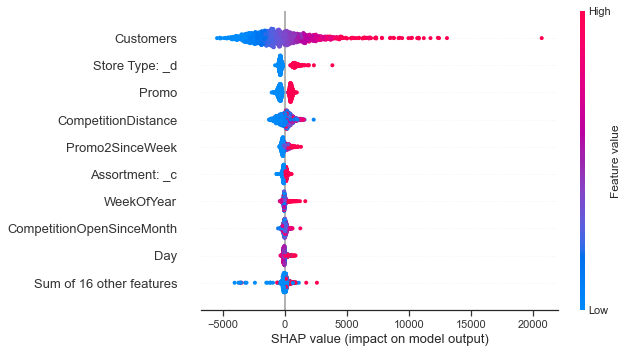

In [229]:
# Visualize the prediction's explanation on beeswarm graph

shap.plots.beeswarm(shap_values)

- **Feature importance**: From top to bottom, features are ranked in order of importance.
- **Impact**: The horizontal position shows whether the effect of the value is associated with a higher or lower prediction.
- **Original value**: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- **Correlation**: A high level of 'Customers' has a high positive impact on the amount of sales predicted. The “high” comes from the red color, and the “positive” impact is shown on the x-axis. Similarly, we can say that just about all of the other features have positive impacts, whether indicated by low negative impacts, or high positive ones.

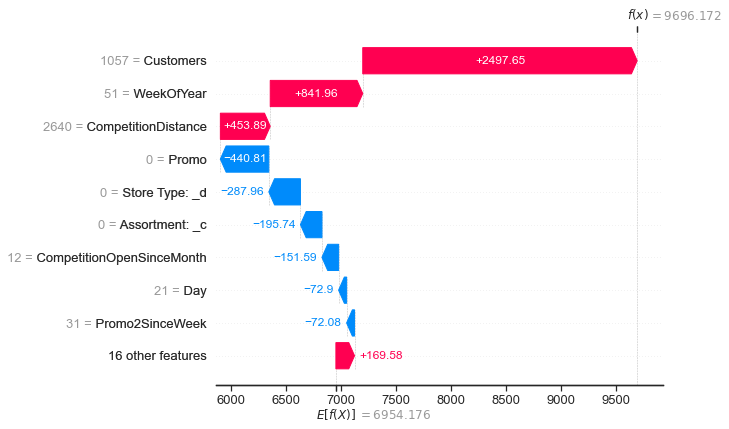

In [230]:
# Visualize the prediction's explanation

shap.plots.waterfall(shap_values[0])

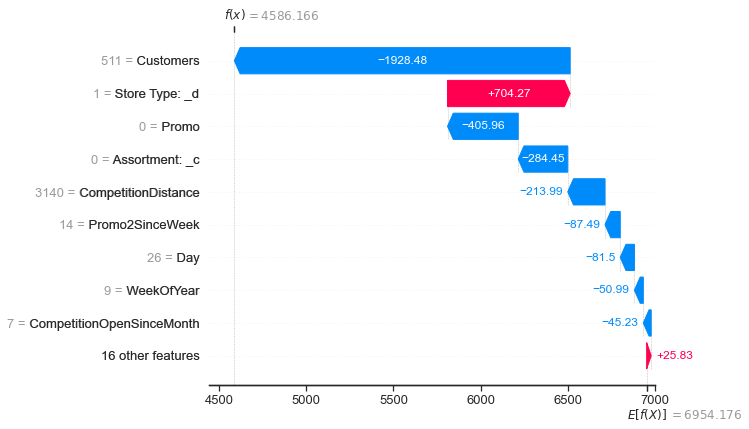

In [237]:
shap.plots.waterfall(shap_values[100])

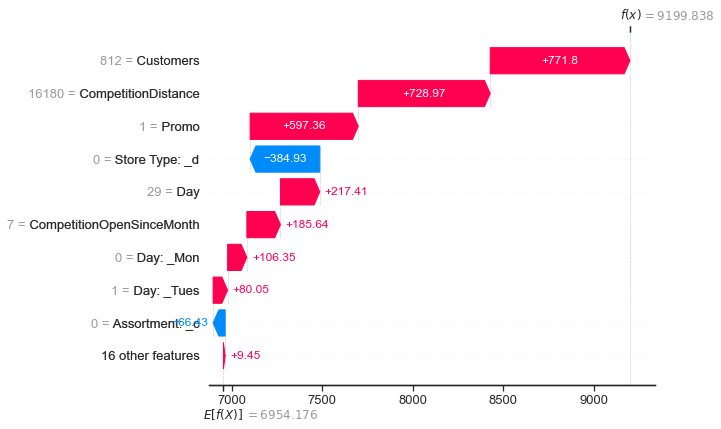

In [238]:
shap.plots.waterfall(shap_values[500])

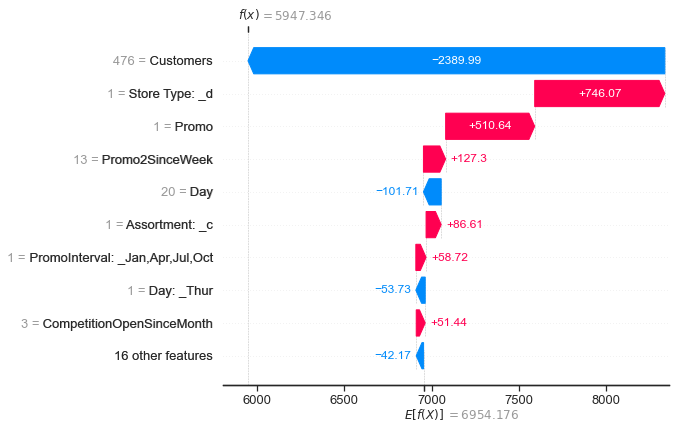

In [240]:
shap.plots.waterfall(shap_values[999])

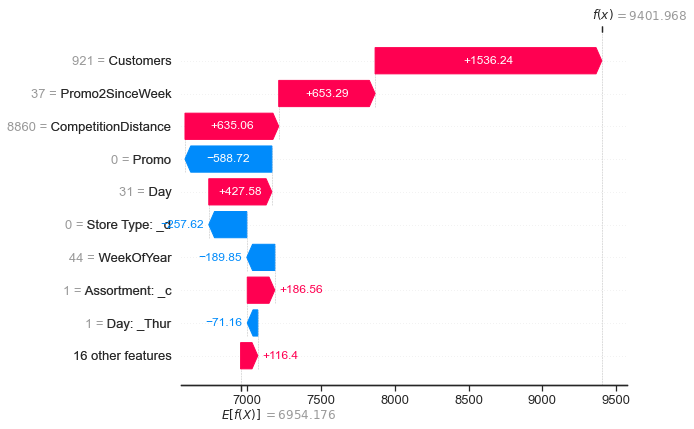

In [234]:
shap.plots.waterfall(shap_values[30])